## Introduction
We choose to work on the Airline On-Time Arrivals. This is a typical binary classification problem. Let delay $>= 15$ min be positive 1 and delay $<15$ min be negative 0. 
<br>
There are several difficulties for this project. First, there are over one hundred fields one can download. We make some simple choices here. We use 'UniqueCarrier' to identify the airline, 'Origin' to represent the origin airport, 'Dest' to represent the destination airport. The choices are mainly based on the completeness of the data. We don't consider cancelled or diverted for simplicity. Secondly, there are tens of millions of data for over three decades. We choose to focus on the year 2016. Using part of the data for training and the other part for testing, we can build a model. This model is expected to give prediction to flight delay in 2017. We expect that the model is only useful for a short period since the air traffic, technology, and administration all evolve quickly. 

In [1]:
import os
import sys
import operator
import pandas as pd
import numpy as np
import random as rnd
import glob

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from scipy import sparse
import xgboost as xgb
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Inpute Data
The first step is to import 2016 data from a local folder. We have already choosen the fields when we download data from the website.

In [2]:
path ='/Users/zhuyuecheng/Dropbox/MachineLearning/Jupynbs/AirlineArrivals' 
allFiles = glob.glob(path + "/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    dfs = pd.read_csv(file_, parse_dates = ['FL_DATE'])
    list_.append(dfs)
df = pd.concat(list_)

In [3]:
df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE UNIQUE_CARRIER  \
0  2016        1      1             6            3 2016-01-06             AA   
1  2016        1      1             7            4 2016-01-07             AA   
2  2016        1      1             8            5 2016-01-08             AA   
3  2016        1      1             9            6 2016-01-09             AA   
4  2016        1      1            10            7 2016-01-10             AA   

  ORIGIN DEST  DEP_DELAY  DEP_DEL15 DEP_TIME_BLK  ARR_DELAY  ARR_DEL15  \
0    DFW  DTW       -3.0        0.0    1100-1159       -6.0        0.0   
1    DFW  DTW       -4.0        0.0    1100-1159      -12.0        0.0   
2    DFW  DTW       -5.0        0.0    1100-1159        7.0        0.0   
3    DFW  DTW        2.0        0.0    1100-1159       -5.0        0.0   
4    DFW  DTW      100.0        1.0    1100-1159      113.0        1.0   

  ARR_TIME_BLK  CRS_ELAPSED_TIME  FLIGHTS  DISTANCE_GROUP  Unnamed: 18  
0    1400-1459             158.0      1.0               4          NaN  
1    1400-1459             158.0      1.0               4          NaN  
2    1400-1459             158.0      1.0               4          NaN  
3    1400-1459             158.0      1.0               4          NaN  
4    1400-1459             158.0      1.0               4          NaN

In [4]:
df.columns

Index([u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK',
       u'FL_DATE', u'UNIQUE_CARRIER', u'ORIGIN', u'DEST', u'DEP_DELAY',
       u'DEP_DEL15', u'DEP_TIME_BLK', u'ARR_DELAY', u'ARR_DEL15',
       u'ARR_TIME_BLK', u'CRS_ELAPSED_TIME', u'FLIGHTS', u'DISTANCE_GROUP',
       u'Unnamed: 18'],
      dtype='object')

In [5]:
df.reset_index(inplace = True)
df = df.drop('index', axis = 1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5617658 entries, 0 to 5617657
Data columns (total 19 columns):
YEAR                int64
QUARTER             int64
MONTH               int64
DAY_OF_MONTH        int64
DAY_OF_WEEK         int64
FL_DATE             datetime64[ns]
UNIQUE_CARRIER      object
ORIGIN              object
DEST                object
DEP_DELAY           float64
DEP_DEL15           float64
DEP_TIME_BLK        object
ARR_DELAY           float64
ARR_DEL15           float64
ARR_TIME_BLK        object
CRS_ELAPSED_TIME    float64
FLIGHTS             float64
DISTANCE_GROUP      int64
Unnamed: 18         float64
dtypes: datetime64[ns](1), float64(7), int64(6), object(5)
memory usage: 814.3+ MB


Drop 'Unnamed: 18'. Choose only 'Flight' == 1.0. We then change 'ARR_DEL15' and 'DEP_DEL15' to int. In order to avoid NA, we convert them to bool first as it fills in NA automatically. 

In [7]:
df = df.drop(['Unnamed: 18'], axis = 1)
df = df[df['FLIGHTS'] == 1.0]
df = df.drop(['FLIGHTS'], axis = 1)
df = df.astype({'ARR_DEL15':bool, 'DEP_DEL15': bool})
df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE UNIQUE_CARRIER  \
0  2016        1      1             6            3 2016-01-06             AA   
1  2016        1      1             7            4 2016-01-07             AA   
2  2016        1      1             8            5 2016-01-08             AA   
3  2016        1      1             9            6 2016-01-09             AA   
4  2016        1      1            10            7 2016-01-10             AA   

  ORIGIN DEST  DEP_DELAY  DEP_DEL15 DEP_TIME_BLK  ARR_DELAY  ARR_DEL15  \
0    DFW  DTW       -3.0      False    1100-1159       -6.0      False   
1    DFW  DTW       -4.0      False    1100-1159      -12.0      False   
2    DFW  DTW       -5.0      False    1100-1159        7.0      False   
3    DFW  DTW        2.0      False    1100-1159       -5.0      False   
4    DFW  DTW      100.0       True    1100-1159      113.0       True   

  ARR_TIME_BLK  CRS_ELAPSED_TIME  DISTANCE_GROUP  
0    1400-1459             158.0               4  
1    1400-1459             158.0               4  
2    1400-1459             158.0               4  
3    1400-1459             158.0               4  
4    1400-1459             158.0               4

In [8]:
df = df.astype({'ARR_DEL15':int, 'DEP_DEL15': int})
df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE UNIQUE_CARRIER  \
0  2016        1      1             6            3 2016-01-06             AA   
1  2016        1      1             7            4 2016-01-07             AA   
2  2016        1      1             8            5 2016-01-08             AA   
3  2016        1      1             9            6 2016-01-09             AA   
4  2016        1      1            10            7 2016-01-10             AA   

  ORIGIN DEST  DEP_DELAY  DEP_DEL15 DEP_TIME_BLK  ARR_DELAY  ARR_DEL15  \
0    DFW  DTW       -3.0          0    1100-1159       -6.0          0   
1    DFW  DTW       -4.0          0    1100-1159      -12.0          0   
2    DFW  DTW       -5.0          0    1100-1159        7.0          0   
3    DFW  DTW        2.0          0    1100-1159       -5.0          0   
4    DFW  DTW      100.0          1    1100-1159      113.0          1   

  ARR_TIME_BLK  CRS_ELAPSED_TIME  DISTANCE_GROUP  
0    1400-1459             158.0               4  
1    1400-1459             158.0               4  
2    1400-1459             158.0               4  
3    1400-1459             158.0               4  
4    1400-1459             158.0               4

In [9]:
df.describe()

YEAR       QUARTER         MONTH  DAY_OF_MONTH   DAY_OF_WEEK  \
count  5617658.0  5.617658e+06  5.617658e+06  5.617658e+06  5.617658e+06   
mean      2016.0  2.511934e+00  6.535810e+00  1.577741e+01  3.933906e+00   
std          0.0  1.105887e+00  3.400847e+00  8.789841e+00  1.985502e+00   
min       2016.0  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%       2016.0  2.000000e+00  4.000000e+00  8.000000e+00  2.000000e+00   
50%       2016.0  3.000000e+00  7.000000e+00  1.600000e+01  4.000000e+00   
75%       2016.0  3.000000e+00  9.000000e+00  2.300000e+01  6.000000e+00   
max       2016.0  4.000000e+00  1.200000e+01  3.100000e+01  7.000000e+00   

          DEP_DELAY     DEP_DEL15     ARR_DELAY     ARR_DEL15  \
count  5.554202e+06  5.617658e+06  5.538145e+06  5.617658e+06   
mean   8.938011e+00  1.810361e-01  3.519290e+00  1.857984e-01   
std    3.976306e+01  3.850481e-01  4.187332e+01  3.889439e-01   
min   -2.040000e+02  0.000000e+00 -1.520000e+02  0.000000e+00   
25%   -5.000000e+00  0.000000e+00 -1.400000e+01  0.000000e+00   
50%   -2.000000e+00  0.000000e+00 -6.000000e+00  0.000000e+00   
75%    6.000000e+00  0.000000e+00  6.000000e+00  0.000000e+00   
max    2.149000e+03  1.000000e+00  2.142000e+03  1.000000e+00   

       CRS_ELAPSED_TIME  DISTANCE_GROUP  
count      5.617652e+06    5.617658e+06  
mean       1.453971e+02    3.872194e+00  
std        7.642798e+01    2.436703e+00  
min        5.000000e+00    1.000000e+00  
25%        8.800000e+01    2.000000e+00  
50%        1.260000e+02    3.000000e+00  
75%        1.780000e+02    5.000000e+00  
max        7.050000e+02    1.100000e+01

Therefore more than 80% flights are on time. 

## Explore Data Analysis
A first analysis of the data. We have 14 features 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_DELAY', 'DEP_DEL15', 'CRS_ELAPSED_TIME', 'DISTANCE_GROUP', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME_BLK', 'ARR_TIME_BLK' to use for the prediction. 

* 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK' are date time.
* 'DEP_DELAY', 'CRS_ELAPSED_TIME' are numerical.
* 'DEP_DEL15', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST' are categorical.
* 'DISTANCE_GROUP','DEP_TIME_BLK', 'ARR_TIME_BLK' are ordinal.


* 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK' are about the time.
* 'DEP_DELAY', 'DEP_DEL15', 'DEST', 'DEP_TIME_BLK', 'ORIGIN' are about the departure.
* 'CRS_ELAPSED_TIME', 'DISTANCE_GROUP' are about the flight duration.
* 'DEST', 'DEP_TIME_BLK', 'ARR_TIME_BLK' are about the arrival condition.
* 'UNIQUE_CARRIER' is the airline.

All five groups should be important.

From the graph, we see arrival delay (ARR_DEL) and departure delay (DEP_DEL) are highly correlated. 

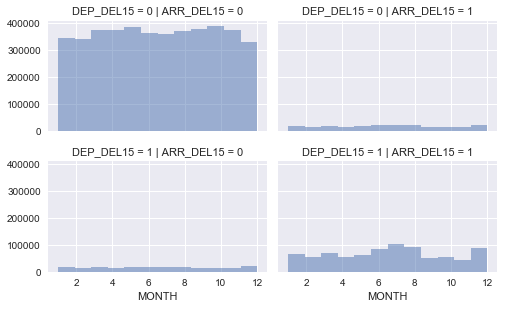

In [10]:
gMonth = sns.FacetGrid(df, row = 'DEP_DEL15', col = 'ARR_DEL15', size = 2.2, aspect = 1.6)
gMonth.map(plt.hist, 'MONTH', alpha = .5, bins = 12)
gMonth.add_legend();

Next consider the distribution of delays in different months. 

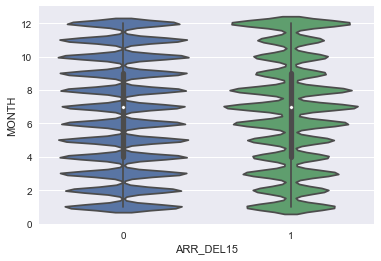

In [11]:
sns.violinplot(x = 'ARR_DEL15', y = 'MONTH', data = df)

In [12]:
byMonth = df[['MONTH','DEP_DELAY','ARR_DELAY','ORIGIN','DEST']].groupby('MONTH').mean()

In [13]:
byMonth

DEP_DELAY  ARR_DELAY
MONTH                      
1       7.793537   1.533654
2       7.487446   0.665299
3       8.341402   3.145914
4       6.278522   0.696820
5       7.381552   2.249006
6      11.699589   7.154742
7      15.084373  10.384151
8      12.564364   8.013417
9       5.616416   0.499182
10      5.493946  -0.223046
11      5.241812  -1.861073
12     13.291119   8.664734

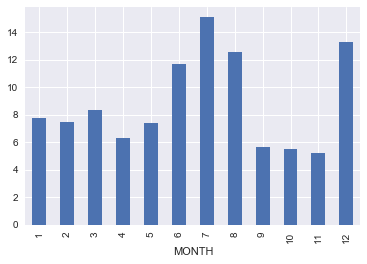

In [14]:
byMonth['DEP_DELAY'].plot(kind = 'bar')

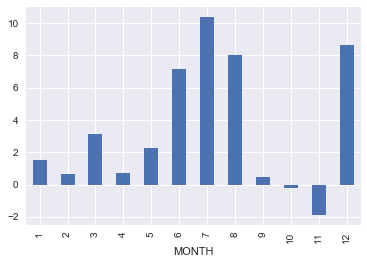

In [15]:
byMonth['ARR_DELAY'].plot(kind = 'bar')

As we can see Jun, Jul, Aug. This is not surprising since summer is the traveling season. There are also a lot of delays in December since it is the holiday season. The cold winter might also contribute to the delays. Sep, Oct, and Nov are the months with fewest delays(in terms of delay time). 

We now compare the delay time for different arrival hours. 

In [16]:
byHour = df[['ARR_TIME_BLK','DEP_DELAY','ARR_DELAY']].groupby('ARR_TIME_BLK').mean()
byHour

DEP_DELAY  ARR_DELAY
ARR_TIME_BLK                      
0001-0559     14.122408   6.096906
0600-0659      4.967505  -1.497441
0700-0759      2.416934  -3.077590
0800-0859      2.136567  -2.502031
0900-0959      2.841372  -1.947445
1000-1059      3.367235  -1.868353
1100-1159      4.746269  -0.482163
1200-1259      5.134797  -0.224390
1300-1359      6.166574   0.725737
1400-1459      7.304934   1.602830
1500-1559      8.586623   3.249055
1600-1659      9.577591   4.360310
1700-1759     11.400965   6.597106
1800-1859     12.496852   7.544444
1900-1959     13.745868   8.792530
2000-2059     14.236785   8.727331
2100-2159     14.810588   9.059990
2200-2259     15.242665   9.093852
2300-2359     14.345661   8.020030

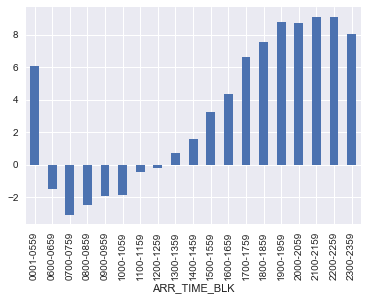

In [17]:
byHour['ARR_DELAY'].plot(kind = 'bar')

This shows that the delays generally get worse towards the end of the day. We think this is partly due to the possiblilties that delays propagate. The peak is around 18:00 - 23:00, the rush hours. 

In [18]:
byDayOfWeek = df[['DAY_OF_WEEK','DEP_DELAY','ARR_DELAY']].groupby('DAY_OF_WEEK').aggregate(np.mean)
byDayOfWeek

DEP_DELAY  ARR_DELAY
DAY_OF_WEEK                      
1             9.307612   3.816911
2             7.911146   2.491794
3             7.542101   2.275777
4             9.956022   5.317991
5            10.497897   5.527220
6             7.981598   1.444029
7             9.152039   3.313080

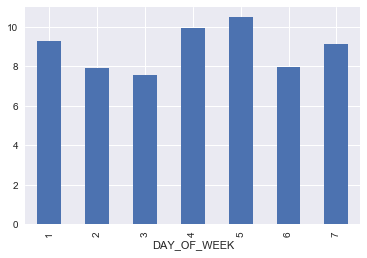

In [19]:
byDayOfWeek['DEP_DELAY'].plot(kind = 'bar')

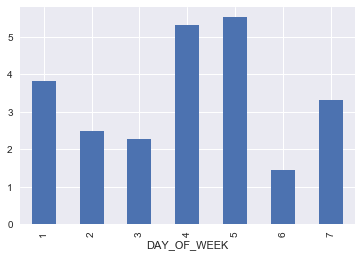

In [20]:
byDayOfWeek['ARR_DELAY'].plot(kind = 'bar')

Therefore Thursday and Friday have the most delays. Saturday usually has fewer delays. 

In [21]:
byDistance = df[['DISTANCE_GROUP','DEP_DELAY','ARR_DELAY']].groupby('DISTANCE_GROUP').aggregate(np.mean)
byDistance.head()

DEP_DELAY  ARR_DELAY
DISTANCE_GROUP                      
1                6.994096   4.003504
2                8.177389   4.262310
3                8.583883   3.275098
4                9.300376   3.615045
5               10.720219   4.650178

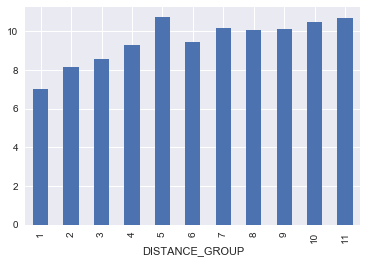

In [22]:
byDistance['DEP_DELAY'].plot(kind = 'bar')

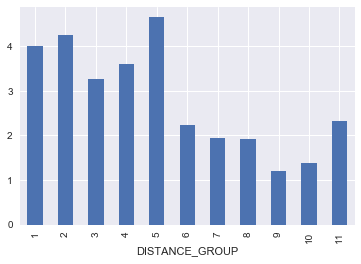

In [23]:
byDistance['ARR_DELAY'].plot(kind = 'bar')

While the distance does not influence the departure delay too much, longer distance leads to less delay. This is probablity due to the practice of buffering the schedules. As there are more flexibility in long distance flights. 

A very naive idea is the the longer distance can compensate the delay of the departure. So it makes sense to compute 'DEP_DELAY'/'CRS_ELAPSED_TIME'

In [24]:
df = df[df['CRS_ELAPSED_TIME'].notnull()]
df = df[df['DEP_DELAY'].notnull()]
df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE UNIQUE_CARRIER  \
0  2016        1      1             6            3 2016-01-06             AA   
1  2016        1      1             7            4 2016-01-07             AA   
2  2016        1      1             8            5 2016-01-08             AA   
3  2016        1      1             9            6 2016-01-09             AA   
4  2016        1      1            10            7 2016-01-10             AA   

  ORIGIN DEST  DEP_DELAY  DEP_DEL15 DEP_TIME_BLK  ARR_DELAY  ARR_DEL15  \
0    DFW  DTW       -3.0          0    1100-1159       -6.0          0   
1    DFW  DTW       -4.0          0    1100-1159      -12.0          0   
2    DFW  DTW       -5.0          0    1100-1159        7.0          0   
3    DFW  DTW        2.0          0    1100-1159       -5.0          0   
4    DFW  DTW      100.0          1    1100-1159      113.0          1   

  ARR_TIME_BLK  CRS_ELAPSED_TIME  DISTANCE_GROUP  
0    1400-1459             158.0               4  
1    1400-1459             158.0               4  
2    1400-1459             158.0               4  
3    1400-1459             158.0               4  
4    1400-1459             158.0               4

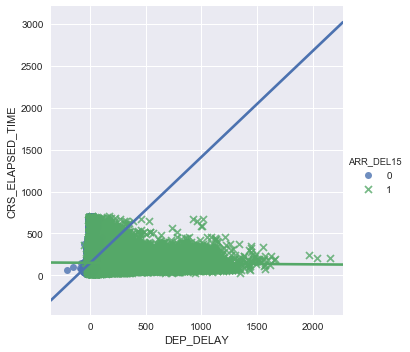

In [25]:
plt.figure(figsize = (10, 10))
g = sns.lmplot(x = 'DEP_DELAY', y = 'CRS_ELAPSED_TIME', hue = 'ARR_DEL15', markers=["o", "x"], data = df)
plt.show()

Compare the delay time for different airlines

In [26]:
df[['UNIQUE_CARRIER','ARR_DEL15']].groupby('UNIQUE_CARRIER', as_index = False).mean().sort_values(by = 'ARR_DEL15', ascending = False)

UNIQUE_CARRIER  ARR_DEL15
7              NK   0.242917
2              B6   0.239908
10             VX   0.230691
5              F9   0.230602
0              AA   0.197161
4              EV   0.182852
11             WN   0.182196
9              UA   0.175049
8              OO   0.166233
3              DL   0.131455
1              AS   0.122949
6              HA   0.087982

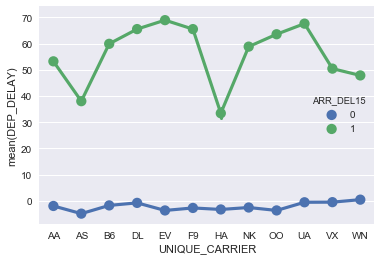

In [27]:
sns.pointplot(x ='UNIQUE_CARRIER', y = 'DEP_DELAY', hue = 'ARR_DEL15', data = df, palette='deep') 

AS and HA are smaller airlines that specializes in paticular routes. That is probably why they don't have a lot delays. While other airlines are much bigger and run flights all over the country. We can divide airlines into bands
(0.15, ) and (0, 0.15].

Compare the delay time for different airports.

In [28]:
byORIGIN = df[['ORIGIN','DEP_DELAY','ARR_DELAY']].groupby('ORIGIN', as_index = False).mean()
byORIGIN.head()

ORIGIN  DEP_DELAY  ARR_DELAY
0    ABE  10.253431   4.038313
1    ABI   9.968354  10.254777
2    ABQ   8.062188   3.831237
3    ABR   5.908719   3.809004
4    ABY   7.714715   3.231231

We choose DFW(South), JFK(East), LAX(West) and ORD(Middle) to represent different geographic areas. Try to see if they perform differently for different seasons. 

In [29]:
origin = []
DFWorigin_df = df[df['ORIGIN'] == 'DFW'].groupby('MONTH', as_index = False).mean()
origin.append(DFWorigin_df)
JFKorigin_df = df[df['ORIGIN'] == 'JFK'].groupby('MONTH', as_index = False).mean()
origin.append(JFKorigin_df)
ORDorigin_df = df[df['ORIGIN'] == 'ORD'].groupby('MONTH', as_index = False).mean()
origin.append(ORDorigin_df)
LAXorigin_df = df[df['ORIGIN'] == 'LAX'].groupby('MONTH', as_index = False).mean()
origin.append(LAXorigin_df)

In [30]:
dest = []
DFWdest_df = df[df['DEST'] == 'DFW'].groupby('MONTH', as_index = False).aggregate(np.mean)
dest.append(DFWdest_df)
JFKdest_df = df[df['DEST'] == 'JFK'].groupby('MONTH', as_index = False).aggregate(np.mean)
dest.append(JFKdest_df)
ORDdest_df = df[df['DEST'] == 'ORD'].groupby('MONTH', as_index = False).aggregate(np.mean)
dest.append(ORDdest_df)
LAXdest_df = df[df['DEST'] == 'LAX'].groupby('MONTH', as_index = False).aggregate(np.mean)
dest.append(LAXdest_df)

We compare the delays for different cities.

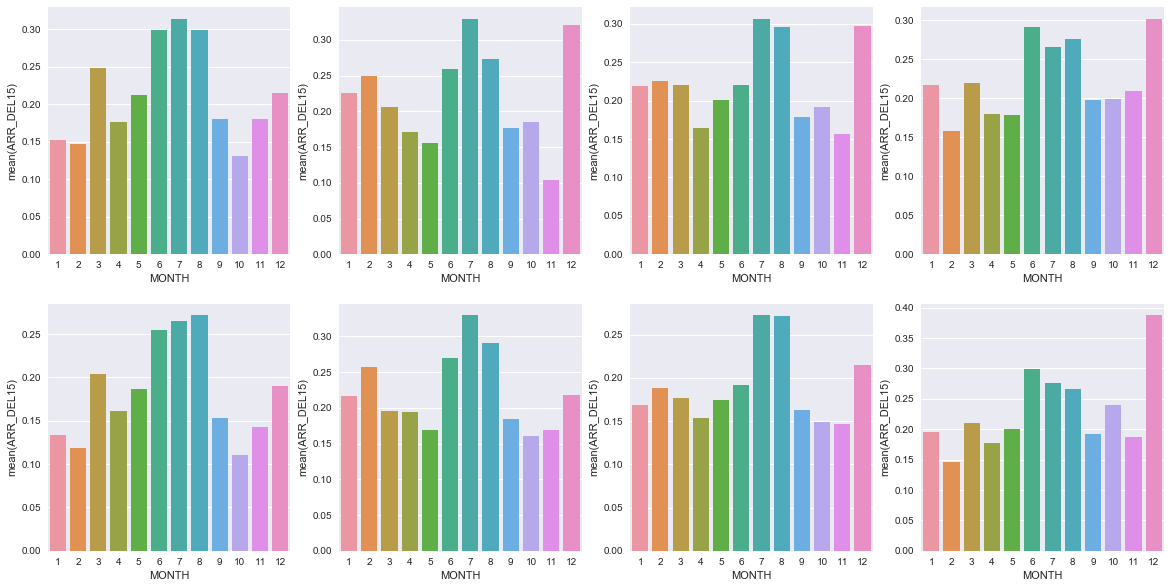

In [31]:
fig, (axis1, axis2) = plt.subplots(2, 4, figsize = (20, 10))
for i in range(4):
    sns.barplot(x = 'MONTH', y = 'ARR_DEL15', data = origin[i], ax = axis1[i])
    sns.barplot(x = 'MONTH', y = 'ARR_DEL15', data = dest[i], ax = axis2[i])

We don't see much differences across different airports as both origin and destination. Except LA has more delays in December. Maybe in December more people are traveling to California. 

Ideally we should group ORIGIN and DEST into different categories by its geographic locations. The information geographic location combined with seasons may give some information. But let's assume that there is no correlation. At least not obvious from the above graphes. 

Due to the limit of time and resource, we will simply classify airports according to their arrival delay. 

In [32]:
train_df, test_df = train_test_split(df, test_size = 0.1, random_state = 3)
train_df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
5609631  2016        3      9            28            3 2016-09-28   
4359897  2016        3      7            29            5 2016-07-29   
3875891  2016        2      6             8            3 2016-06-08   
3490887  2016        2      5            15            7 2016-05-15   
3046492  2016        2      4            20            3 2016-04-20   

        UNIQUE_CARRIER ORIGIN DEST  DEP_DELAY  DEP_DEL15 DEP_TIME_BLK  \
5609631             EV    AEX  ATL       -6.0          0    1300-1359   
4359897             OO    DEN  SEA        4.0          0    1200-1259   
3875891             NK    DFW  ORD       -4.0          0    1600-1659   
3490887             WN    SJC  LAS       56.0          1    1600-1659   
3046492             UA    ORD  MCO       -5.0          0    0900-0959   

         ARR_DELAY  ARR_DEL15 ARR_TIME_BLK  CRS_ELAPSED_TIME  DISTANCE_GROUP  
5609631      -11.0          0    1600-1659             102.0               3  
4359897       16.0          1    1400-1459             179.0               5  
3875891       -5.0          0    1900-1959             148.0               4  
3490887       42.0          1    1700-1759              80.0               2  
3046492       -2.0          0    1200-1259             163.0               5

In [33]:
combine = [train_df, test_df]

## Feature Engineering

1) Construct a new feature 'DEP_DELAY/CRS_ELAPSED_TIME'
<br>
2) Drop 'YEAR', 'QUATER', 'DAY_OF_MONTH', 'ORIGIN', 'DISTANCE_GROUP', 'DEP_TIME_BLK'
<br>
3) BAND 'UNIQUE_CARRIER', 'DEST' into groups
<br>
4) BAND 'ARR_TIME_BAND' further.

In [34]:
train_df['UNIT_DELAY'] = train_df['DEP_DELAY']*1.0/(train_df['CRS_ELAPSED_TIME'])

/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [35]:
llimit = np.percentile(train_df['UNIT_DELAY'].values, 1)
ulimit = np.percentile(train_df['UNIT_DELAY'].values, 99) 
print llimit, ulimit

-0.171428571429 1.55625


In [36]:
def remove_outlier(data) :
    data.replace(np.inf, ulimit)
    data.replace(np.inf, llimit)
    data.loc[data['UNIT_DELAY'] < llimit, 'UNIT_DELAY'] = llimit
    data.loc[data['UNIT_DELAY'] > ulimit, 'UNIT_DELAY'] = ulimit

In [37]:
test_df['UNIT_DELAY'] = test_df['DEP_DELAY']/(test_df['CRS_ELAPSED_TIME'])
for dataset in combine :
    remove_outlier(dataset)

/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Preprocessing numeric values
Use Standardization

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df['UNIT_DELAY'].reshape(-1,1))
train_df['UNIT_DELAY'] = scaler.transform(train_df['UNIT_DELAY'].values.reshape(-1,1))
test_df['UNIT_DELAY'] = scaler.transform(test_df['UNIT_DELAY'].values.reshape(-1,1))

/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
train_df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
5609631  2016        3      9            28            3 2016-09-28   
4359897  2016        3      7            29            5 2016-07-29   
3875891  2016        2      6             8            3 2016-06-08   
3490887  2016        2      5            15            7 2016-05-15   
3046492  2016        2      4            20            3 2016-04-20   

        UNIQUE_CARRIER ORIGIN DEST  DEP_DELAY  DEP_DEL15 DEP_TIME_BLK  \
5609631             EV    AEX  ATL       -6.0          0    1300-1359   
4359897             OO    DEN  SEA        4.0          0    1200-1259   
3875891             NK    DFW  ORD       -4.0          0    1600-1659   
3490887             WN    SJC  LAS       56.0          1    1600-1659   
3046492             UA    ORD  MCO       -5.0          0    0900-0959   

         ARR_DELAY  ARR_DEL15 ARR_TIME_BLK  CRS_ELAPSED_TIME  DISTANCE_GROUP  \
5609631      -11.0          0    1600-1659             102.0               3   
4359897       16.0          1    1400-1459             179.0               5   
3875891       -5.0          0    1900-1959             148.0               4   
3490887       42.0          1    1700-1759              80.0               2   
3046492       -2.0          0    1200-1259             163.0               5   

         UNIT_DELAY  
5609631   -0.470682  
4359897   -0.154409  
3875891   -0.346789  
3490887    2.486025  
3046492   -0.361002

In [40]:
byDEST = train_df[['DEST', 'ARR_DEL15']].groupby('DEST', as_index = False).mean()
byDEST.head()


DEST  ARR_DEL15
0  ABE   0.176753
1  ABI   0.209459
2  ABQ   0.182313
3  ABR   0.098336
4  ABY   0.180110

In [41]:
byDEST['DEST_BAND'] = pd.cut(byDEST['ARR_DEL15'], 5)
byDEST[['DEST_BAND', 'ARR_DEL15']].groupby(['DEST_BAND'],\
                                          as_index=False).mean().sort_values(by='DEST_BAND', ascending=True)

DEST_BAND  ARR_DEL15
0  (-0.000367, 0.0735]   0.056704
1      (0.0735, 0.147]   0.119605
2        (0.147, 0.22]   0.175866
3        (0.22, 0.294]   0.246235
4       (0.294, 0.367]   0.331898

In [42]:
byDEST.head()

DEST  ARR_DEL15        DEST_BAND
0  ABE   0.176753    (0.147, 0.22]
1  ABI   0.209459    (0.147, 0.22]
2  ABQ   0.182313    (0.147, 0.22]
3  ABR   0.098336  (0.0735, 0.147]
4  ABY   0.180110    (0.147, 0.22]

In [43]:
byDEST['BAND'] = 0
byDEST.loc[ byDEST['ARR_DEL15'] <= 0.0735, 'BAND'] = 0
byDEST.loc[(byDEST['ARR_DEL15'] > 0.0735) & (byDEST['ARR_DEL15'] <= 0.147), 'BAND'] = 1
byDEST.loc[(byDEST['ARR_DEL15'] > 0.147) & (byDEST['ARR_DEL15'] <= 0.22), 'BAND'] = 2
byDEST.loc[(byDEST['ARR_DEL15'] > 0.22) & (byDEST['ARR_DEL15'] <= 0.294), 'BAND'] = 3
byDEST.loc[ byDEST['ARR_DEL15'] > 0.294, 'BAND'] = 4
byDEST.head()

DEST  ARR_DEL15        DEST_BAND  BAND
0  ABE   0.176753    (0.147, 0.22]     2
1  ABI   0.209459    (0.147, 0.22]     2
2  ABQ   0.182313    (0.147, 0.22]     2
3  ABR   0.098336  (0.0735, 0.147]     1
4  ABY   0.180110    (0.147, 0.22]     2

In [44]:
dest_map = pd.Series(byDEST.BAND.values,index=byDEST.DEST).to_dict()
def add_Band(data):
    data['DEST_AIRPORT'] = data['DEST'].map(dest_map)

for data in combine :
    add_Band(data)

train_df.head()

/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
5609631  2016        3      9            28            3 2016-09-28   
4359897  2016        3      7            29            5 2016-07-29   
3875891  2016        2      6             8            3 2016-06-08   
3490887  2016        2      5            15            7 2016-05-15   
3046492  2016        2      4            20            3 2016-04-20   

        UNIQUE_CARRIER ORIGIN DEST  DEP_DELAY  DEP_DEL15 DEP_TIME_BLK  \
5609631             EV    AEX  ATL       -6.0          0    1300-1359   
4359897             OO    DEN  SEA        4.0          0    1200-1259   
3875891             NK    DFW  ORD       -4.0          0    1600-1659   
3490887             WN    SJC  LAS       56.0          1    1600-1659   
3046492             UA    ORD  MCO       -5.0          0    0900-0959   

         ARR_DELAY  ARR_DEL15 ARR_TIME_BLK  CRS_ELAPSED_TIME  DISTANCE_GROUP  \
5609631      -11.0          0    1600-1659             102.0               3   
4359897       16.0          1    1400-1459             179.0               5   
3875891       -5.0          0    1900-1959             148.0               4   
3490887       42.0          1    1700-1759              80.0               2   
3046492       -2.0          0    1200-1259             163.0               5   

         UNIT_DELAY  DEST_AIRPORT  
5609631   -0.470682             1  
4359897   -0.154409             2  
3875891   -0.346789             2  
3490887    2.486025             2  
3046492   -0.361002             2

In [45]:
#As a very simple model, use 'MONTH', 'DAY_OF_WEEK', 'DEP_DELAY', 'DISTANCE_GROUP', 'DEST', 'ARR_TIME_BLK','UNIQUE_CARRIER' should already gives a simple model. 

sample_df = train_df[['ARR_DEL15','UNIT_DELAY']]

In [46]:
sample_df['UNIT_DELAY'].isnull().values.any()

False

In [47]:
sampletrain_df, valid_df = train_test_split(sample_df, test_size = 0.2)

In [48]:
X_train = sampletrain_df.drop(['ARR_DEL15'], axis=1)
X_test = valid_df.drop(['ARR_DEL15'], axis = 1)
Y_train = sampletrain_df['ARR_DEL15']
Y_test = valid_df['ARR_DEL15']

In [49]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = accuracy_score(Y_pred, Y_test)
acc_log

0.92544280804516299

In [50]:
target_names = ['ONTIME', 'DELAYED']
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.93      0.98      0.96    823270
    DELAYED       0.88      0.67      0.76    176486

avg / total       0.92      0.93      0.92    999756



We find UNIT_DELAY is linear correlated to the delay. This is already a good prediction. 

In [51]:
train_df = pd.get_dummies(train_df, columns = ['UNIQUE_CARRIER'])
test_df = pd.get_dummies(test_df, columns = ['UNIQUE_CARRIER'])
train_df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE ORIGIN  \
5609631  2016        3      9            28            3 2016-09-28    AEX   
4359897  2016        3      7            29            5 2016-07-29    DEN   
3875891  2016        2      6             8            3 2016-06-08    DFW   
3490887  2016        2      5            15            7 2016-05-15    SJC   
3046492  2016        2      4            20            3 2016-04-20    ORD   

        DEST  DEP_DELAY  DEP_DEL15        ...         UNIQUE_CARRIER_B6  \
5609631  ATL       -6.0          0        ...                         0   
4359897  SEA        4.0          0        ...                         0   
3875891  ORD       -4.0          0        ...                         0   
3490887  LAS       56.0          1        ...                         0   
3046492  MCO       -5.0          0        ...                         0   

         UNIQUE_CARRIER_DL  UNIQUE_CARRIER_EV UNIQUE_CARRIER_F9  \
5609631                  0                  1                 0   
4359897                  0                  0                 0   
3875891                  0                  0                 0   
3490887                  0                  0                 0   
3046492                  0                  0                 0   

         UNIQUE_CARRIER_HA  UNIQUE_CARRIER_NK  UNIQUE_CARRIER_OO  \
5609631                  0                  0                  0   
4359897                  0                  0                  1   
3875891                  0                  1                  0   
3490887                  0                  0                  0   
3046492                  0                  0                  0   

         UNIQUE_CARRIER_UA  UNIQUE_CARRIER_VX  UNIQUE_CARRIER_WN  
5609631                  0                  0                  0  
4359897                  0                  0                  0  
3875891                  0                  0                  0  
3490887                  0                  0                  1  
3046492                  1                  0                  0  

[5 rows x 30 columns]

In [52]:
dict = {'0001-0559': 0}
for i in range(6, 24):
    pre = str(i)
    if len(pre) < 2 :
        pre = '0' + pre
    period = pre + '00'+'-' + pre + '59'
    dict[period] = i - 5
dict

{'0001-0559': 0,
 '0600-0659': 1,
 '0700-0759': 2,
 '0800-0859': 3,
 '0900-0959': 4,
 '1000-1059': 5,
 '1100-1159': 6,
 '1200-1259': 7,
 '1300-1359': 8,
 '1400-1459': 9,
 '1500-1559': 10,
 '1600-1659': 11,
 '1700-1759': 12,
 '1800-1859': 13,
 '1900-1959': 14,
 '2000-2059': 15,
 '2100-2159': 16,
 '2200-2259': 17,
 '2300-2359': 18}

In [53]:
train_df = train_df.drop(['YEAR','QUARTER','FL_DATE', 'ORIGIN', 'DEST', 'DEP_DELAY','DEP_DEL15', \
                      'DEP_TIME_BLK', 'ARR_DELAY','CRS_ELAPSED_TIME', 'DISTANCE_GROUP'], axis = 1)
test_df = test_df.drop(['YEAR','QUARTER','FL_DATE', 'ORIGIN', 'DEST', 'DEP_DELAY','DEP_DEL15', \
                      'DEP_TIME_BLK', 'ARR_DELAY','CRS_ELAPSED_TIME', 'DISTANCE_GROUP'], axis = 1)
train_df.head()

MONTH  DAY_OF_MONTH  DAY_OF_WEEK  ARR_DEL15 ARR_TIME_BLK  UNIT_DELAY  \
5609631      9            28            3          0    1600-1659   -0.470682   
4359897      7            29            5          1    1400-1459   -0.154409   
3875891      6             8            3          0    1900-1959   -0.346789   
3490887      5            15            7          1    1700-1759    2.486025   
3046492      4            20            3          0    1200-1259   -0.361002   

         DEST_AIRPORT  UNIQUE_CARRIER_AA  UNIQUE_CARRIER_AS  \
5609631             1                  0                  0   
4359897             2                  0                  0   
3875891             2                  0                  0   
3490887             2                  0                  0   
3046492             2                  0                  0   

         UNIQUE_CARRIER_B6  UNIQUE_CARRIER_DL  UNIQUE_CARRIER_EV  \
5609631                  0                  0                  1   
4359897                  0                  0                  0   
3875891                  0                  0                  0   
3490887                  0                  0                  0   
3046492                  0                  0                  0   

         UNIQUE_CARRIER_F9  UNIQUE_CARRIER_HA  UNIQUE_CARRIER_NK  \
5609631                  0                  0                  0   
4359897                  0                  0                  0   
3875891                  0                  0                  1   
3490887                  0                  0                  0   
3046492                  0                  0                  0   

         UNIQUE_CARRIER_OO  UNIQUE_CARRIER_UA  UNIQUE_CARRIER_VX  \
5609631                  0                  0                  0   
4359897                  1                  0                  0   
3875891                  0                  0                  0   
3490887                  0                  0                  0   
3046492                  0                  1                  0   

         UNIQUE_CARRIER_WN  
5609631                  0  
4359897                  0  
3875891                  0  
3490887                  1  
3046492                  0

In [54]:
train_df.columns.values

array(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ARR_DEL15', 'ARR_TIME_BLK',
       'UNIT_DELAY', 'DEST_AIRPORT', 'UNIQUE_CARRIER_AA',
       'UNIQUE_CARRIER_AS', 'UNIQUE_CARRIER_B6', 'UNIQUE_CARRIER_DL',
       'UNIQUE_CARRIER_EV', 'UNIQUE_CARRIER_F9', 'UNIQUE_CARRIER_HA',
       'UNIQUE_CARRIER_NK', 'UNIQUE_CARRIER_OO', 'UNIQUE_CARRIER_UA',
       'UNIQUE_CARRIER_VX', 'UNIQUE_CARRIER_WN'], dtype=object)

In [55]:
train_df['ARR_TIME_BLK'] = train_df['ARR_TIME_BLK'].map(dict)
test_df['ARR_TIME_BLK'] = test_df['ARR_TIME_BLK'].map(dict)
train_df.head()

MONTH  DAY_OF_MONTH  DAY_OF_WEEK  ARR_DEL15  ARR_TIME_BLK  \
5609631      9            28            3          0            11   
4359897      7            29            5          1             9   
3875891      6             8            3          0            14   
3490887      5            15            7          1            12   
3046492      4            20            3          0             7   

         UNIT_DELAY  DEST_AIRPORT  UNIQUE_CARRIER_AA  UNIQUE_CARRIER_AS  \
5609631   -0.470682             1                  0                  0   
4359897   -0.154409             2                  0                  0   
3875891   -0.346789             2                  0                  0   
3490887    2.486025             2                  0                  0   
3046492   -0.361002             2                  0                  0   

         UNIQUE_CARRIER_B6  UNIQUE_CARRIER_DL  UNIQUE_CARRIER_EV  \
5609631                  0                  0                  1   
4359897                  0                  0                  0   
3875891                  0                  0                  0   
3490887                  0                  0                  0   
3046492                  0                  0                  0   

         UNIQUE_CARRIER_F9  UNIQUE_CARRIER_HA  UNIQUE_CARRIER_NK  \
5609631                  0                  0                  0   
4359897                  0                  0                  0   
3875891                  0                  0                  1   
3490887                  0                  0                  0   
3046492                  0                  0                  0   

         UNIQUE_CARRIER_OO  UNIQUE_CARRIER_UA  UNIQUE_CARRIER_VX  \
5609631                  0                  0                  0   
4359897                  1                  0                  0   
3875891                  0                  0                  0   
3490887                  0                  0                  0   
3046492                  0                  1                  0   

         UNIQUE_CARRIER_WN  
5609631                  0  
4359897                  0  
3875891                  0  
3490887                  1  
3046492                  0

In [56]:
train_df.isnull().values.any()

False

In [57]:
test_df.isnull().values.any()

True

In [58]:
null_data = test_df[test_df.isnull().any(axis=1)]
null_data

MONTH  DAY_OF_MONTH  DAY_OF_WEEK  ARR_DEL15  ARR_TIME_BLK  UNIT_DELAY  \
886591     10            21            5          0             2   -0.338891   

        DEST_AIRPORT  UNIQUE_CARRIER_AA  UNIQUE_CARRIER_AS  UNIQUE_CARRIER_B6  \
886591           NaN                  0                  0                  0   

        UNIQUE_CARRIER_DL  UNIQUE_CARRIER_EV  UNIQUE_CARRIER_F9  \
886591                  0                  0                  0   

        UNIQUE_CARRIER_HA  UNIQUE_CARRIER_NK  UNIQUE_CARRIER_OO  \
886591                  0                  0                  0   

        UNIQUE_CARRIER_UA  UNIQUE_CARRIER_VX  UNIQUE_CARRIER_WN  
886591                  1                  0                  0

In [59]:
test_df = test_df.dropna()

## Train Models

In [60]:
X_train = train_df.drop(['ARR_DEL15'], axis = 1)
X_test  = test_df.drop(['ARR_DEL15'], axis = 1)
Y_train = train_df['ARR_DEL15']
Y_test = test_df['ARR_DEL15']
Y_test.head()

3128612    0
947750     1
2566795    0
2440972    0
5370066    0
Name: ARR_DEL15, dtype: int64

In [61]:
X_train.shape, X_test.shape

((4998776, 18), (555419, 18))

First, we use a single model. Pick models from Linear Regression, Linear SVC, Gaussian Naive Bayes, Perceptron, Decision Tree and Random Forest.

In [62]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = accuracy_score(Y_test, Y_pred)
acc_log

0.92751238254362922

In [63]:
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

Feature  Correlation
4          UNIT_DELAY     4.272302
5        DEST_AIRPORT     0.386905
11  UNIQUE_CARRIER_F9     0.234872
13  UNIQUE_CARRIER_NK     0.194879
6   UNIQUE_CARRIER_AA     0.181278
7   UNIQUE_CARRIER_AS     0.142801
8   UNIQUE_CARRIER_B6     0.052702
3        ARR_TIME_BLK     0.015589
0               MONTH     0.007925
1        DAY_OF_MONTH     0.001360
2         DAY_OF_WEEK    -0.010269
16  UNIQUE_CARRIER_VX    -0.032453
14  UNIQUE_CARRIER_OO    -0.295973
15  UNIQUE_CARRIER_UA    -0.368034
10  UNIQUE_CARRIER_EV    -0.421655
9   UNIQUE_CARRIER_DL    -0.582442
17  UNIQUE_CARRIER_WN    -0.669425
12  UNIQUE_CARRIER_HA    -0.868455

In [64]:
target_names = ['ONTIME', 'DELAYED']
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.93      0.98      0.96    457551
    DELAYED       0.89      0.68      0.77     97868

avg / total       0.93      0.93      0.92    555419



In [65]:
print(accuracy_score(Y_test, Y_pred))

0.927512382544


In [66]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = accuracy_score(Y_test, Y_pred)
acc_gaussian

0.88025076563819382

In [67]:
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.94      0.91      0.93    457551
    DELAYED       0.64      0.72      0.68     97868

avg / total       0.89      0.88      0.88    555419



In [68]:
print(accuracy_score(Y_test, Y_pred))

0.880250765638


In [69]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


91.47

In [70]:
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.95      0.95      0.95    457551
    DELAYED       0.76      0.75      0.75     97868

avg / total       0.91      0.91      0.91    555419



In [71]:
print(accuracy_score(Y_test, Y_pred))

0.914255724057


In [72]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = accuracy_score(Y_test, Y_pred)
acc_decision_tree

0.88722027874451537

In [73]:
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.93      0.93      0.93    457551
    DELAYED       0.68      0.69      0.68     97868

avg / total       0.89      0.89      0.89    555419



In [74]:
print(accuracy_score(Y_test, Y_pred))

0.887220278745


In [75]:
# Random Forest 

random_forest = RandomForestClassifier(n_estimators=100, min_samples_split=20, max_depth=10, random_state=3)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = accuracy_score(Y_test, Y_pred)
acc_random_forest

0.92721350908053202

In [76]:
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.94      0.98      0.96    457551
    DELAYED       0.87      0.69      0.77     97868

avg / total       0.92      0.93      0.92    555419



In [77]:
print(accuracy_score(Y_test, Y_pred))

0.927213509081


In [78]:
# AdaBoost

adaboost = AdaBoostClassifier(n_estimators=100, random_state=3)
adaboost.fit(X_train, Y_train)
Y_pred = adaboost.predict(X_test)
adaboost.score(X_train, Y_train)
acc_adaboost = accuracy_score(Y_test, Y_pred)
acc_adaboost

0.92717750022955647

In [79]:
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.94      0.98      0.96    457551
    DELAYED       0.87      0.68      0.77     97868

avg / total       0.92      0.93      0.92    555419



The conclusion is to use the logistic regression.

In [80]:
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
print(classification_report(Y_test, Y_pred, target_names=target_names))
print acc_log

             precision    recall  f1-score   support

     ONTIME       0.93      0.98      0.96    457551
    DELAYED       0.89      0.68      0.77     97868

avg / total       0.93      0.93      0.92    555419

0.927512382544


## Evaluation
Evaluation of the models: Logistic regression, Random Forest, and AdaBoost are the best. The results are also close to the simple model using only one feature 'UNIT_DELAY'. Therefore there is no essential improvement from including other features. The f1 score is 0.92, which is quite good. The accuracy is 0.9275.

## Stacking
Next, we see if stacking can improve the prediction. 

In [81]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 3 # for reproducibility
NFOLDS = 4 # set folds for out-of-fold prediction

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, params = {}):
        self.clf = clf(**params)

    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)

    def predict(self, X):
        return self.clf.predict(X)
    
    def fit(self,X,y):
        return self.clf.fit(X,y)
    
    def feature_importances(self,X,y):
        print(self.clf.fit(X,y).feature_importances_)

In [82]:
from sklearn.model_selection import StratifiedKFold;
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=23)
kf.get_n_splits(X_train.values, Y_train.values)

4

In [83]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [84]:
# parameters for AdaBoost
ada_params = {
    'n_estimators' : 200,
    'random_state' : SEED
}
# parameters for random forest
rf_params = {
    'min_samples_split' : 20,
    'n_estimators': 200,
    'max_depth' : 10,
    'verbose' : 0,
    'random_state' : SEED
}

In [85]:
ada = SklearnHelper(clf=AdaBoostClassifier, params =ada_params)
log = SklearnHelper(clf=LogisticRegression)
rf = SklearnHelper(clf=RandomForestClassifier, params=rf_params)

In [86]:
x_train = X_train.values
x_test = X_test.values
y_train = Y_train.ravel()

In [87]:
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
log_oof_train, log_oof_test = get_oof(log, x_train, y_train, x_test)
print 'Training complete'

Training complete


In [88]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                        'AdaBoost' : ada_oof_train.ravel(),
                                        'LogisticRegression' : log_oof_train.ravel()
                                      })
base_predictions_train.head()

AdaBoost  LogisticRegression  RandomForest
0       0.0                 0.0           0.0
1       0.0                 0.0           0.0
2       0.0                 0.0           0.0
3       1.0                 1.0           1.0
4       0.0                 0.0           0.0

In [89]:
x_train = np.concatenate((rf_oof_train, ada_oof_train, log_oof_train), axis=1)
x_test = np.concatenate((rf_oof_test, ada_oof_test, log_oof_test), axis=1)

In [90]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
Y_pred = gbm.predict(x_test)
print accuracy_score(Y_test, Y_pred)
print(classification_report(Y_test, Y_pred, target_names=target_names))

0.927499779446
             precision    recall  f1-score   support

     ONTIME       0.93      0.98      0.96    457551
    DELAYED       0.88      0.68      0.77     97868

avg / total       0.93      0.93      0.92    555419



## Conclusion
The conclusion is the engineered feature 'UNIT_DELAY' alone can predict the arrival delay very well. The stacking does not improve the performance. The explaination is that the makeup minutes / flight minute is almost fixed. The longer the flight is, the more delayed time can be saved. It basically determines whether a flight will arrive at the destination on time. The conditions on the arrival airport do not matter that much. 

## Possible Improvement
This prediction is based on the condition that we have the information about the departure. That is the prediction can only be made after the flight takes off. However, if we want to predict delays before the departure, we need to predict the departure delays as well. For that case, it is better to include weather data. Moreover, if the target flight is scheduled late in the day, we can also include data about the early delays of filghts. 